In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import MyCounter, HUEOrder

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.subplots as plsp
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from collections import Counter

pd.set_option('display.max_columns', None)
plt.rc('font',family = 'serif')
TD_colors = plt.cm.get_cmap('flag', 20) #Paired, flag
colors_ = sns.color_palette('viridis', 20)
CSS_colors = [mcolors.to_hex(TD_colors(i)) for i in range(20)]
path = "../data/"

In [3]:
# Obtained from Optimization
min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.insert(loc=2,column="label_str",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label_str"] = "Decreasing"

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


In [4]:
features = ['TAUTH','NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

DB5 = tokamakTK.clean_categorical_data(DB5)

In [5]:
# alpha_R -- 0.6358 --> when considering DB2 for calculation
data1 = DB5[DB5.label.isin([1])].reset_index(drop=True)
# alpha_R -- 2.1246 --> when considering DB2 for calculation
data2 = DB5[DB5.label.isin([0])]
# Removing DB2, because most of these shots have missing info
data2 = data2[~data2.id.isin(DB2.id.values)].reset_index(drop=True)

data = [data1,data2]

In [6]:
#tokamakTK.get_regression(data1, DB2)[1].summary()

In [7]:
# Needed for Improved Visualization in Plots

HUE_ORDER = {}

HUE_ORDER["ICSCHEME"] = dict(zip(sorted(data1["ICSCHEME"].unique()), colors_[:len(data1["ICSCHEME"].unique())]))
HUE_ORDER["ELMTYPE"] = dict(zip(sorted(data1["ELMTYPE"].unique()), colors_[:len(data1["ELMTYPE"].unique())]))
HUE_ORDER["HYBRID"] = dict(zip(sorted(data1["HYBRID"].unique()), colors_[:len(data1["HYBRID"].unique())]))
HUE_ORDER["AUXHEAT"] = dict(zip(sorted(data1["AUXHEAT"].unique()), colors_[:len(data1["AUXHEAT"].unique())]))
HUE_ORDER["DIVMAT"] = dict(zip(sorted(data1["DIVMAT"].unique()), colors_[:len(data1["DIVMAT"].unique())]))
HUE_ORDER["WALMAT"] = dict(zip(sorted(data1["WALMAT"].unique()), colors_[:len(data1["WALMAT"].unique())]))
HUE_ORDER["EVAP"] = dict(zip(sorted(data1["EVAP"].unique()), colors_[:len(data1["EVAP"].unique())]))
HUE_ORDER["ECHMODE"] = dict(zip(sorted(data1["ECHMODE"].unique()), colors_[:len(data1["ECHMODE"].unique())]))
HUE_ORDER["PELLET"] = dict(zip(sorted(data1["PELLET"].unique()), colors_[:len(data1["PELLET"].unique())]))
HUE_ORDER["CONFIG"] = dict(zip(sorted(data1["CONFIG"].unique()), colors_[:len(data1["CONFIG"].unique())]))
HUE_ORDER["LIMMAT"] = dict(zip(sorted(data1["LIMMAT"].unique()), colors_[:len(data1["LIMMAT"].unique())]))
HUE_ORDER["TOK"] = dict(zip(sorted(data1["TOK"].unique()), colors_[:len(data1["TOK"].unique())]))

PX_ORDER = {}


PX_ORDER["ICSCHEME"] = dict(zip(sorted(data1["ICSCHEME"].unique()), CSS_colors[:len(data1["ICSCHEME"].unique())]))
PX_ORDER["ELMTYPE"] = dict(zip(sorted(data1["ELMTYPE"].unique()), CSS_colors[:len(data1["ELMTYPE"].unique())]))
PX_ORDER["HYBRID"] = dict(zip(sorted(data1["HYBRID"].unique()), CSS_colors[:len(data1["HYBRID"].unique())]))
PX_ORDER["AUXHEAT"] = dict(zip(sorted(data1["AUXHEAT"].unique()), CSS_colors[:len(data1["AUXHEAT"].unique())]))
PX_ORDER["DIVMAT"] = dict(zip(sorted(data1["DIVMAT"].unique()), CSS_colors[:len(data1["DIVMAT"].unique())]))
PX_ORDER["WALMAT"] = dict(zip(sorted(data1["WALMAT"].unique()), CSS_colors[:len(data1["WALMAT"].unique())]))
PX_ORDER["EVAP"] = dict(zip(sorted(data1["EVAP"].unique()), CSS_colors[:len(data1["EVAP"].unique())]))
PX_ORDER["ECHMODE"] = dict(zip(sorted(data1["ECHMODE"].unique()), CSS_colors[:len(data1["ECHMODE"].unique())]))
PX_ORDER["PELLET"] = dict(zip(sorted(data1["PELLET"].unique()), CSS_colors[:len(data1["PELLET"].unique())]))
PX_ORDER["CONFIG"] = dict(zip(sorted(data1["CONFIG"].unique()), CSS_colors[:len(data1["CONFIG"].unique())]))
PX_ORDER["LIMMAT"] = dict(zip(sorted(data1["LIMMAT"].unique()), CSS_colors[:len(data1["LIMMAT"].unique())]))
PX_ORDER["TOK"] = dict(zip(sorted(data1["TOK"].unique()), CSS_colors[:len(data1["TOK"].unique())]))


hue_order = HUEOrder(HUE_ORDER)

## RHOSTAR vs NUSTAR

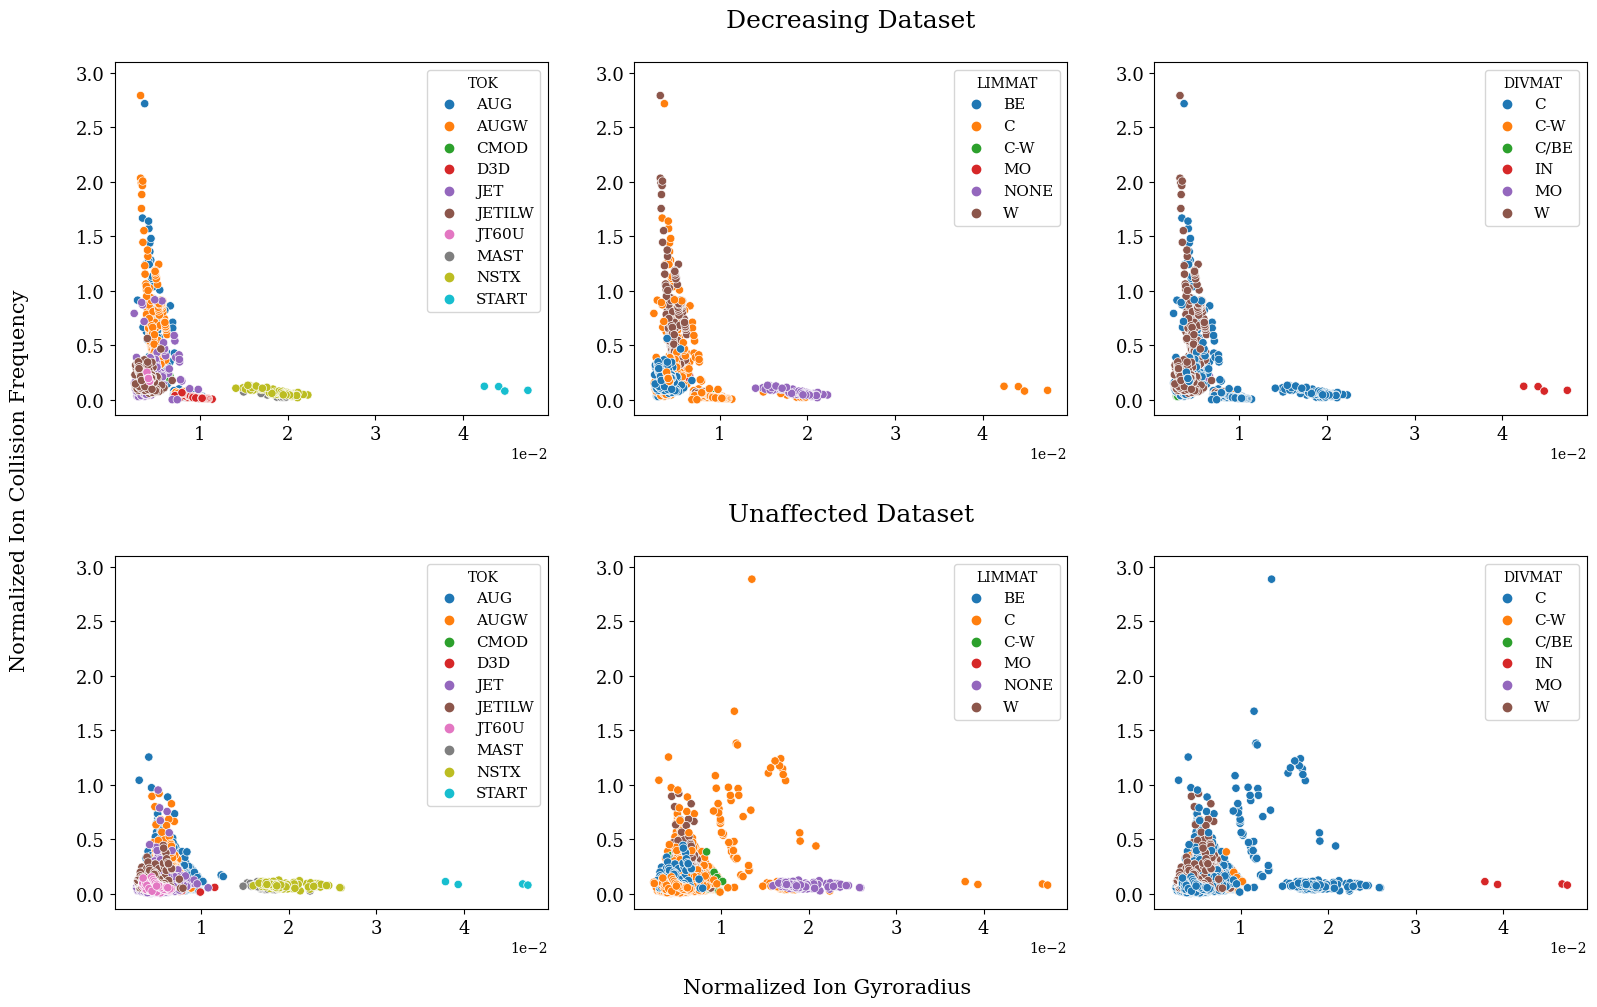

In [8]:
params = {
    "HUE_ORDER": HUE_ORDER,
    "cat_params": ["TOK", "LIMMAT", "DIVMAT"] ,
    "xy__params": ["RHOSTAR", "NUSTAR"],
    "x___label": "Normalized Ion Gyroradius" ,
    "y___label": "Normalized Ion Collision Frequency",
    "plot_size": (19, 11),
    "x__minmax": (None, None),
    "y__minmax": (None, 3.1),
    "fig_format": "pdf",
    "save_fig": False
}

tokamakTK.scatter_data_comparison(data, params)

**NORMALIZED ION COLLISION FREQUENCY (NICF)**

- large if NICF > 1
- small if NICF < 0.1


* A large NICF means that the ion-ion collision frequency is much greater than the ion gyrofrequency. This indicates that collisions between ions are very frequent and that the plasma is strongly collisional. In a strongly collisional plasma, the ions are more likely to lose their energy through collisions with other ions and with the neutral particles, rather than through the electromagnetic processes that lead to fusion reactions. As a result, achieving fusion in such a plasma can be more challenging.

* On the other hand, a small NICF means that the ion-ion collision frequency is much smaller than the ion gyrofrequency. This indicates that collisions between ions are rare and that the plasma is weakly collisional. In a weakly collisional plasma, the ions can retain their energy for longer periods of time, which can increase the likelihood of fusion reactions occurring. However, maintaining a weakly collisional plasma can also be challenging, as it requires careful control of the plasma parameters and the magnetic field geometry.

---

**NORMALIZED ION GYRORADIUS (NIGR)**

- large if NIGR > 0.1
- small if NIGR < 0.01


* A large NIGR means that the ion gyroradius is much larger than the plasma minor radius. This indicates that the ions are strongly affected by the magnetic field and that their motion is constrained to a narrow region around the magnetic field lines. In such a plasma, the ions are less likely to collide with each other, and are more likely to collide with the walls of the plasma confinement vessel. This can lead to increased wall erosion and other problems.

* On the other hand, a small NIGR means that the ion gyroradius is much smaller than the plasma minor radius. This indicates that the ions are less strongly affected by the magnetic field and that their motion can be more diffuse. In such a plasma, the ions are more likely to collide with each other and to undergo fusion reactions. However, maintaining a small NIGR can also be challenging, as it requires a carefully designed magnetic field geometry that balances the confinement of the plasma with the need to maintain a high fusion reactivity.

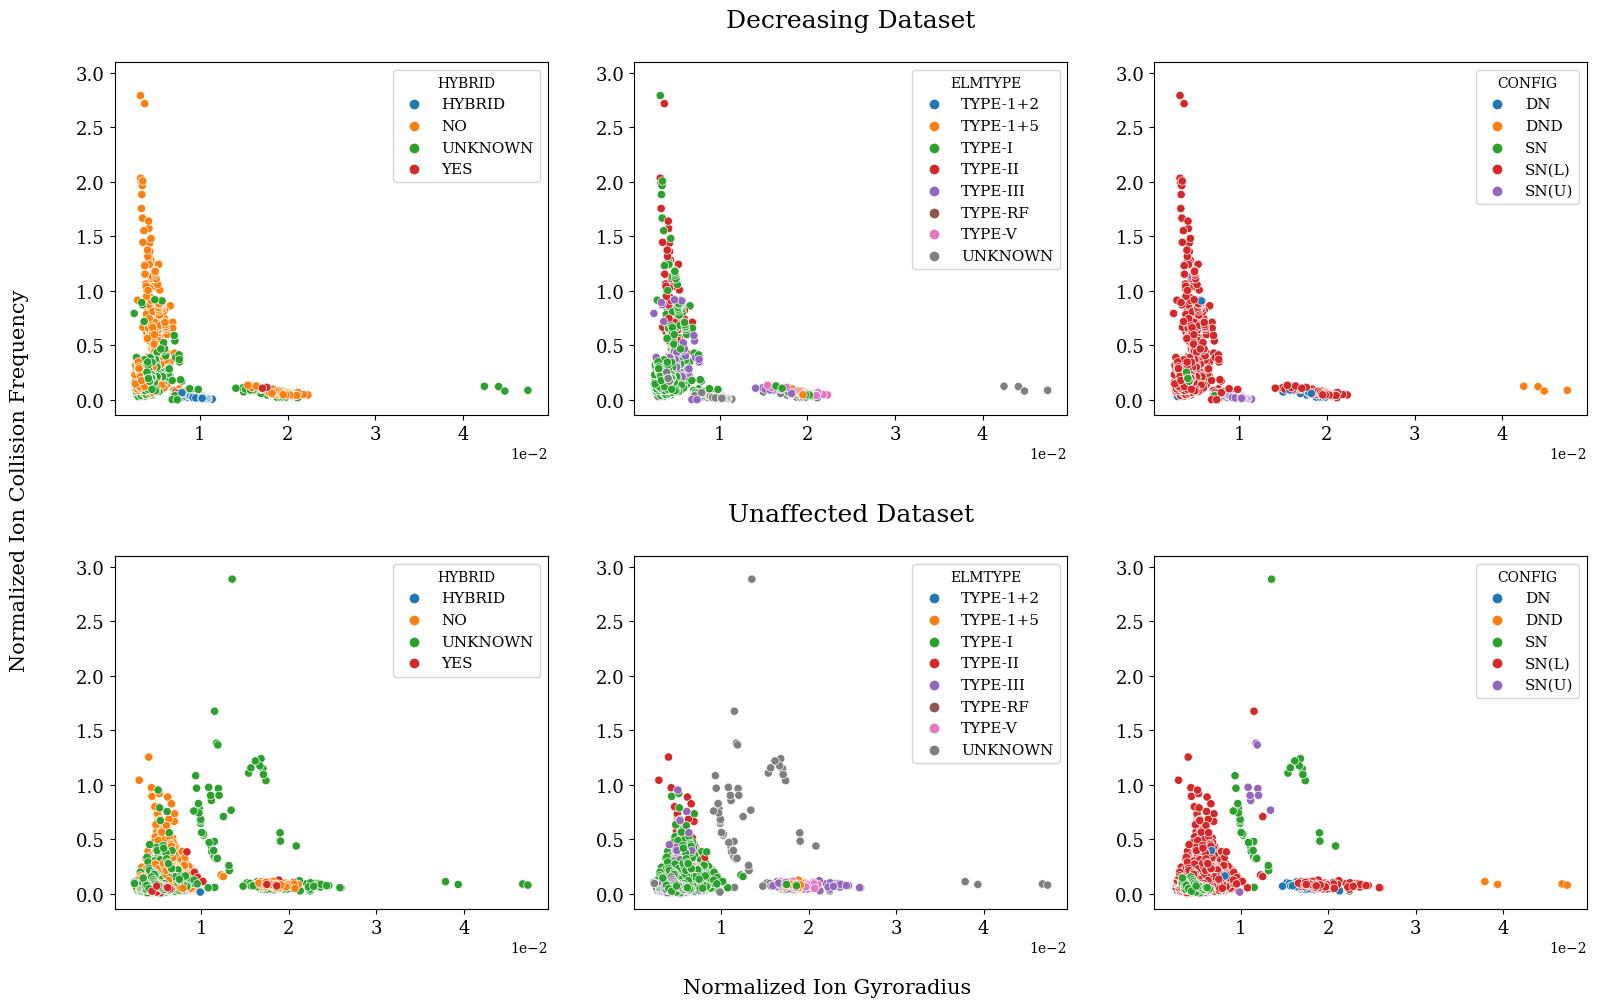

In [9]:
params = {
    "HUE_ORDER": HUE_ORDER,
    "cat_params": ["HYBRID", "ELMTYPE", "CONFIG"] ,
    "xy__params": ["RHOSTAR", "NUSTAR"],
    "x___label": "Normalized Ion Gyroradius" ,
    "y___label": "Normalized Ion Collision Frequency",
    "plot_size": (19, 11),
    "x__minmax": (None, None),
    "y__minmax": (None, 3.1),
    "fig_format": "pdf",
    "save_fig": False
}

tokamakTK.scatter_data_comparison(data, params)

In [10]:
# size = "TAUBOHM"
# symbol="TOK"
px.scatter_3d(data_frame=data1, x="NUSTAR", y="RHOSTAR", z="TAV", 
              color="TOK", color_discrete_map=PX_ORDER["TOK"])

In [11]:
px.scatter_3d(data_frame=data2, x="NUSTAR", y="RHOSTAR", z="TAV", 
              color="TOK", color_discrete_map=PX_ORDER["TOK"])

In [12]:
px.scatter_3d(data_frame=DB5, x="NUSTAR", y="RHOSTAR", z="TAV", 
              color="label_str", color_discrete_map={"Decreasing":"red","Unaffected":"black"})

In [13]:
px.scatter_3d(data_frame=DB5, x="TAUTH", y="BETASTAR", z="NUSTAR", 
              color="label_str", color_discrete_map={"Decreasing":"red","Unaffected":"black"})

In [14]:
px.scatter_3d(data_frame=DB5, x="TAUTH", y="RHOSTAR", z="NUSTAR", 
              color="label_str", color_discrete_map={"Decreasing":"red","Unaffected":"black"})